In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ.setdefault('GLUE_SETTINGS_MODULE', 'settings')

'settings'

In [3]:
import sm_net
from flowfairy.conf import settings

In [4]:
batch_size = settings.BATCH_SIZE
samplerate = settings.SAMPLERATE

In [5]:
x = tf.placeholder(tf.float32, [64, samplerate])
cls = tf.placeholder(tf.int32, 64)

In [6]:
with tf.variable_scope('network'):
    net = sm_net.conv_net(x, cls, None)

conv1:  Tensor("network/glu_conv1_1/mul:0", shape=(64, 11024, 1, 4), dtype=float32)
conv2:  Tensor("network/glu_conv2_1/mul:0", shape=(64, 5512, 1, 8), dtype=float32)
conv3:  Tensor("network/glu_conv3_1/mul:0", shape=(64, 2756, 1, 64), dtype=float32)
conv4:  Tensor("network/glu_conv4_1/mul:0", shape=(64, 1378, 1, 64), dtype=float32)
embedded: Tensor("network/embedding/concat:0", shape=(64, 689, 1, 66), dtype=float32)
conv5:  Tensor("network/glu_conv5_1/mul:0", shape=(64, 689, 1, 64), dtype=float32)
d2s_6:  Tensor("network/d2s1/DepthToSpace:0", shape=(64, 2756, 4, 4), dtype=float32)
conv6:  Tensor("network/glu_conv6_2/mul:0", shape=(64, 2756, 1, 64), dtype=float32)
d2s_7:  Tensor("network/d2s2/DepthToSpace:0", shape=(64, 11024, 4, 4), dtype=float32)
conv7:  Tensor("network/glu_conv8_2/mul:0", shape=(64, 11024, 1, 64), dtype=float32)
clsifyer:  Tensor("network/glu_clsifyer/mul:0", shape=(64, 11024, 1, 256), dtype=float32)
out:  Tensor("network/output/Reshape:0", shape=(64, 11024, 256), d

In [7]:
saver = tf.train.Saver()

In [8]:
sess = tf.InteractiveSession()

In [9]:
saver.restore(sess, 'logs/emb_mid2.ckpt-1000')

INFO:tensorflow:Restoring parameters from logs/emb_mid2.ckpt-1000


In [10]:
coll = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
c1uw = coll[0]

In [12]:
i=0
for i, v in enumerate(coll):
    print(i,v)

0 <tf.Variable 'network/conv1_1_unit/weights:0' shape=(128, 1, 1, 4) dtype=float32_ref>
1 <tf.Variable 'network/conv1_1_unit/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
2 <tf.Variable 'network/conv1_1_gate/weights:0' shape=(128, 1, 1, 4) dtype=float32_ref>
3 <tf.Variable 'network/conv1_1_gate/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
4 <tf.Variable 'network/conv2_1_unit/weights:0' shape=(128, 1, 4, 8) dtype=float32_ref>
5 <tf.Variable 'network/conv2_1_unit/biases:0' shape=(8,) dtype=float32_ref>
6 <tf.Variable 'network/conv2_1_gate/weights:0' shape=(128, 1, 4, 8) dtype=float32_ref>
7 <tf.Variable 'network/conv2_1_gate/biases:0' shape=(8,) dtype=float32_ref>
8 <tf.Variable 'network/conv3_1_unit/weights:0' shape=(128, 1, 8, 64) dtype=float32_ref>
9 <tf.Variable 'network/conv3_1_unit/biases:0' shape=(64,) dtype=float32_ref>
10 <tf.Variable 'network/conv3_1_gate/weights:0' shape=(128, 1, 8, 64) dtype=float32_ref>
11 <tf.Variable 'network/conv3_1_gate/biases:0' shape=(64,) dtype=f

<tf.Variable 'network/embedding/embedding:0' shape=(200, 2) dtype=float32_ref>


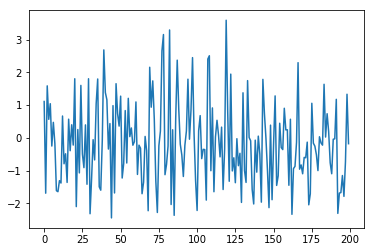

In [17]:
embedding = coll[16]
print(embedding)
plt.plot(embedding.eval().sum(axis=1))
plt.show()

In [ ]:
def classify(val):
    val = (val-np.min(val))/(np.max(val)-np.min(val))
    return np.floor(val*255)


In [ ]:
myrange = np.arange(samplerate) / samplerate
mysine = np.sin(myrange * np.pi * 2 * 135)
mysine2 = np.sin(myrange * np.pi * 2 * 150)

plt.plot(mysine)
plt.show()

In [ ]:
print(mysine.shape)
print(np.array([mysine]).shape)

In [ ]:
pred = tf.argmax(net, 2)
b=np.tile(classify(mysine+mysine2),(64,1))
y=np.arange(136,200)
run = sess.run(pred, feed_dict={x: b, cls: y})

In [ ]:

[plt.plot(run[1000:1100]) for run in run]
plt.plot(classify(mysine)[1000:1100], 'b', alpha=0.5)
plt.plot(classify(mysine2)[1000:1100], 'g', alpha=0.5)
plt.show()

In [ ]:
(150-120)/3
